# Supervised Learning : NBA Shots Log Data (DS-SF-25 | Final Project)

## Importing and Reading Data

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn import neighbors, metrics, grid_search, cross_validation
from sklearn import tree, ensemble, metrics, cross_validation, externals
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
def read_dataset(x):
    return pd.read_csv(os.path.join('..', 'datasets', x))
train_2_df = read_dataset('train_2pts.csv')
test_2_df = read_dataset('test_2pts.csv')

In [3]:
# dropping the index from the from the prior data read for EDA purpose.
train_2_df = train_2_df.drop('Unnamed: 0',1)
test_2_df = test_2_df.drop('Unnamed: 0',1)

In [4]:
train_2_df.head(2)

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,PTS,player_name,player_id,Month,location_t,GAME_CLOCK_t,SHOT_CLOCK_t,Catch&Shot,SHOT_DISTANCE,CLOSEST_DEFENDER_DISTANE
0,21400530,"JAN 07, 2015 - DEN vs. ORL",H,W,3,7,3,9:51,8.6,0,...,2,jusuf nurkic,203994,JAN,0,2031.0,2,1,6,4
1,21400325,"DEC 10, 2014 - MIA @ DEN",A,L,-20,5,2,11:12,12.9,2,...,0,dwayne wade,2548,DEC,1,1392.0,3,0,8,2


In [5]:
# Correlation table for significant features
train_2_df[['SHOT_NUMBER','GAME_CLOCK_t','Catch&Shot','SHOT_CLOCK','SHOT_DIST','CLOSE_DEF_DIST','FGM']].corr()

,SHOT_NUMBER,GAME_CLOCK_t,Catch&Shot,SHOT_CLOCK,SHOT_DIST,CLOSE_DEF_DIST,FGM
SHOT_NUMBER,1.000000,0.583843,-0.081208,-0.039460,0.007986,-0.019974,-0.004529
GAME_CLOCK_t,0.583843,1.000000,-0.022117,-0.043919,-0.000534,-0.016598,-0.008079
Catch&Shot,-0.081208,-0.022117,1.000000,0.170867,-0.031228,0.154217,0.094551
SHOT_CLOCK,-0.039460,-0.043919,0.170867,1.000000,-0.247157,0.014916,0.116830
SHOT_DIST,0.007986,-0.000534,-0.031228,-0.247157,1.000000,0.461443,-0.168766
CLOSE_DEF_DIST,-0.019974,-0.016598,0.154217,0.014916,0.461443,1.000000,0.051432
FGM,-0.004529,-0.008079,0.094551,0.116830,-0.168766,0.051432,1.000000


In [6]:
corr=train_2_df[['SHOT_NUMBER','GAME_CLOCK_t','Catch&Shot','SHOT_CLOCK','SHOT_DIST','CLOSE_DEF_DIST','FGM']].corr()

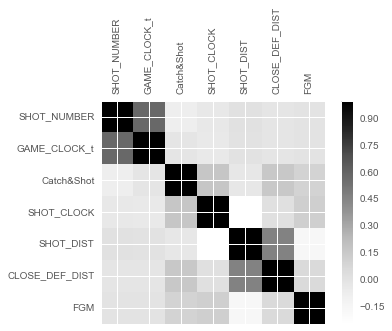

In [7]:
# Correlation heatmap
list(corr.columns)
figure = plt.figure()
subplot = figure.add_subplot(1, 1, 1)
figure.colorbar(subplot.matshow(corr))
subplot.set_xticklabels([None] + list(corr.columns), rotation = 90)
subplot.set_yticklabels([None] + list(corr.columns))

## Modeling

In [8]:
train_y = train_2_df.FGM
test_y = test_2_df.FGM

#### Guessing the Majority Class

Train Result

In [9]:
# predict all missed shots
train_2_df['model_1_y_hat']=0

In [10]:
#Confusion Matrix
pd.crosstab(train_y, train_2_df.model_1_y_hat, rownames = ['True Class'], colnames = ['Hypothesized Class'])

Hypothesized Class,0
True Class,
0,27865
1,26646


In [11]:
#Null accuracy rate
27647./(26558+27647)

0.5100451987824002

Test Result

In [12]:
test_2_df['model_1_y_hat']=0

In [13]:
pd.crosstab(test_y, test_2_df.model_1_y_hat, rownames = ['True Class'], colnames = ['Hypothesized Class'])

Hypothesized Class,0
True Class,
0,18370
1,17764


In [14]:
#Null accuracy rate
18519./(17822+18519)

0.5095897196004513

#### Logistic Regression

In [15]:
#Logistic 1: all significant features
train_X = train_2_df[['SHOT_NUMBER','GAME_CLOCK_t','Catch&Shot','SHOT_CLOCK','SHOT_DIST','CLOSE_DEF_DIST']]

In [16]:
logit = linear_model.LogisticRegression().\
    fit(train_X, train_y)

In [17]:
print logit.coef_
print logit.intercept_

[[  5.81183507e-03  -2.40008728e-05   2.19927692e-01   1.79643147e-02
   -7.34469989e-02   1.59836586e-01]]
[-0.20312466]


In [18]:
# Confusion matrix
pd.crosstab(train_y, logit.predict(train_X), rownames = ['True Class'], colnames = ['Hypothesized Class'])

Hypothesized Class,0,1
True Class,,
0,17932,9933
1,11776,14870


In [19]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)
    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

In [20]:
def confusion_matrix_cal(cm):
    print "Accuracy =", metrics.accuracy_score(train_y,logit.predict(train_X))
    print "True positive rate =", float(cm[1][1])/(cm[1][0]+cm[1][1])
    print "False positive rate =", float(cm[0][1])/(cm[0][1]+cm[0][0])
    print "Specificity =", float(cm[0][0])/(cm[0][0]+cm[0][1])
    print "Precision", float(cm[1][1])/(cm[0][1]+cm[1][1])
    print "Improvement compared to null error rate =", metrics.accuracy_score(train_y,logit.predict(train_X))- 27647./(26558+27647)

Normalized confusion matrix
[[ 0.64353131  0.35646869]
 [ 0.44194251  0.55805749]]


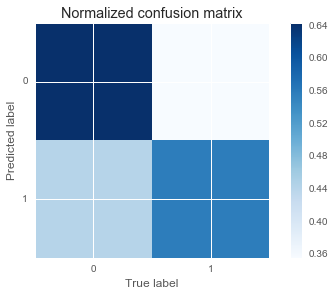

In [21]:
cm = metrics.confusion_matrix(train_y,logit.predict(train_X))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [22]:
#Confusion matrix metrics:
confusion_matrix_cal(cm)

Accuracy = 0.601750105483
True positive rate = 0.558057494558
False positive rate = 0.356468688319
Specificity = 0.643531311681
Precision 0.599524251099
Improvement compared to null error rate = 0.0917049067009


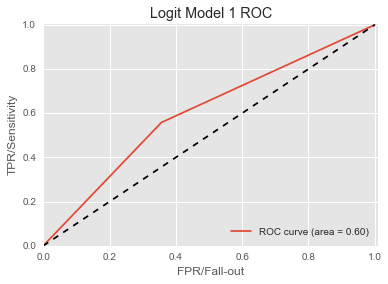

In [23]:
#ROC
fpr, tpr, thresholds = metrics.roc_curve(train_y, logit.predict(train_X))

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Logit Model 1 ROC")
plt.legend(loc = 'lower right')
plt.show()

In [56]:
#Logistic 2: Only Shot Distance, Closest Defender and Catch&Shot
train_X = train_2_df[['Catch&Shot','SHOT_DIST','CLOSE_DEF_DIST']]

In [57]:
logit = linear_model.LogisticRegression().\
    fit(train_X, train_y)

In [58]:
print logit.coef_
print logit.intercept_

[[ 0.24630496 -0.07796142  0.16546286]]
[ 0.03948843]


In [59]:
# Accuracy for 
logit.score(train_X, train_y)

0.60046596099869753

In [28]:
pd.crosstab(train_y, logit.predict(train_X), rownames = ['Hypothesized Class'], colnames = ['True Class'])

True Class,0,1
Hypothesized Class,,
0,17702,10163
1,11616,15030


Normalized confusion matrix
[[ 0.63527723  0.36472277]
 [ 0.43593785  0.56406215]]


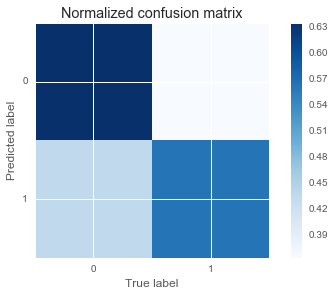

In [29]:
cm = metrics.confusion_matrix(train_y,logit.predict(train_X))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [30]:
confusion_matrix_cal(cm)

Accuracy = 0.600465960999
True positive rate = 0.564062148165
False positive rate = 0.364722770501
Specificity = 0.635277229499
Precision 0.596594292065
Improvement compared to null error rate = 0.0904207622163


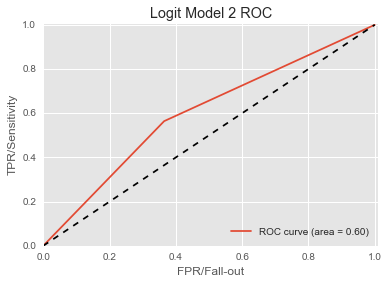

In [32]:
#ROC
fpr, tpr, thresholds = metrics.roc_curve(train_y, logit.predict(train_X))

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Logit Model 2 ROC")
plt.legend(loc = 'lower right')
plt.show()

In [33]:
#Logistic 3: Only Shot Distance
train_X = train_2_df[['SHOT_DIST']]

In [34]:
logit = linear_model.LogisticRegression().\
    fit(train_X, train_y)

In [35]:
print logit.coef_
print logit.intercept_

[[-0.0503703]]
[ 0.43775656]


In [36]:
pd.crosstab(train_y, logit.predict(train_X), rownames = ['Hypothesized Class'], colnames = ['True Class'])

True Class,0,1
Hypothesized Class,,
0,14521,13344
1,9843,16803


Normalized confusion matrix
[[ 0.52111968  0.47888032]
 [ 0.36939878  0.63060122]]


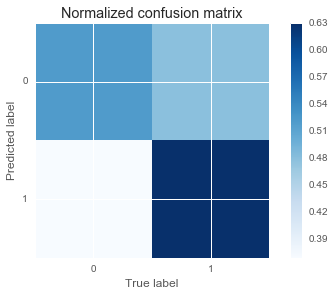

In [37]:
cm = metrics.confusion_matrix(train_y,logit.predict(train_X))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [38]:
confusion_matrix_cal(cm)

Accuracy = 0.574636311937
True positive rate = 0.630601215942
False positive rate = 0.478880315808
Specificity = 0.521119684192
Precision 0.557368892427
Improvement compared to null error rate = 0.0645911131546


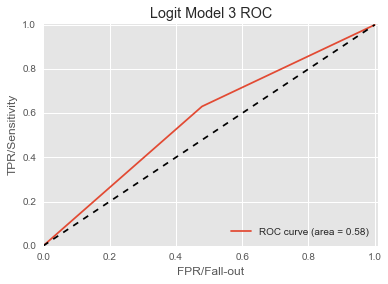

In [39]:
#ROC
fpr, tpr, thresholds = metrics.roc_curve(train_y, logit.predict(train_X))

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Logit Model 3 ROC")
plt.legend(loc = 'lower right')
plt.show()

In [40]:
#Logistic 4: Only Shot Distance and Catch%Shot
train_X = train_2_df[['SHOT_DIST','Catch&Shot']]

In [41]:
logit = linear_model.LogisticRegression().\
    fit(train_X, train_y)

In [42]:
print logit.coef_
print logit.intercept_

[[-0.04988438  0.37630108]]
[ 0.28416732]


In [43]:
# Accuracy for 
logit.score(train_X, train_y)

0.59032121957036199

In [44]:
pd.crosstab(train_y, logit.predict(train_X), rownames = ['Hypothesized Class'], colnames = ['True Class'])

True Class,0,1
Hypothesized Class,,
0,17535,10330
1,12002,14644


Normalized confusion matrix
[[ 0.62928405  0.37071595]
 [ 0.45042408  0.54957592]]


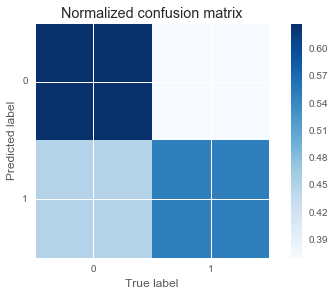

In [45]:
cm = metrics.confusion_matrix(train_y,logit.predict(train_X))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [46]:
confusion_matrix_cal(cm)

Accuracy = 0.59032121957
True positive rate = 0.549575921339
False positive rate = 0.370715951911
Specificity = 0.629284048089
Precision 0.586369824618
Improvement compared to null error rate = 0.080276020788


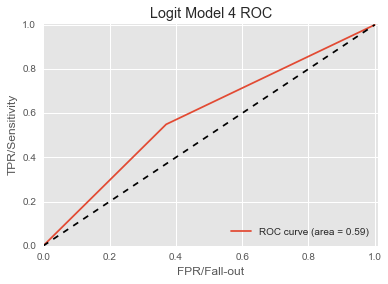

In [47]:
#ROC
fpr, tpr, thresholds = metrics.roc_curve(train_y, logit.predict(train_X))

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Logit Model 4 ROC")
plt.legend(loc = 'lower right')
plt.show()

In [48]:
#Logistic 4: Only Shot Distance and Catch%Shot
train_X = train_2_df[['SHOT_DIST','CLOSE_DEF_DIST']]

In [49]:
logit = linear_model.LogisticRegression().\
    fit(train_X, train_y)

In [50]:
print logit.coef_
print logit.intercept_

[[-0.08099588  0.18114361]]
[ 0.11336785]


In [51]:
# Accuracy for 
logit.score(train_X, train_y)

0.59402689365449179

In [52]:
pd.crosstab(train_y, logit.predict(train_X), rownames = ['Hypothesized Class'], colnames = ['True Class'])

True Class,0,1
Hypothesized Class,,
0,17035,10830
1,11300,15346


Normalized confusion matrix
[[ 0.61134039  0.38865961]
 [ 0.42407866  0.57592134]]


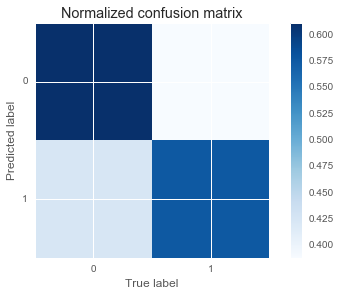

In [53]:
cm = metrics.confusion_matrix(train_y,logit.predict(train_X))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [54]:
confusion_matrix_cal(cm)

Accuracy = 0.594026893654
True positive rate = 0.575921339038
False positive rate = 0.388659608828
Specificity = 0.611340391172
Precision 0.586262224939
Improvement compared to null error rate = 0.0839816948721


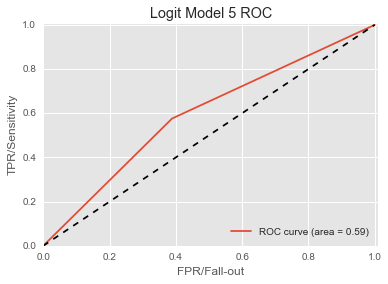

In [55]:
#ROC
fpr, tpr, thresholds = metrics.roc_curve(train_y, logit.predict(train_X))

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Logit Model 5 ROC")
plt.legend(loc = 'lower right')
plt.show()

#### Logistic Model Compare

Metrics| Logit_1 | Logit_2 | Logit_3 | Logit_4 | Logit_5
---|---|---
Accuracy | 0.6012729453	 | 0.600110690896 | 0.589631952772 |0.589631952772| 0.594465455216
True positive rate | 0.559567738535 | 0.56502748701 |0.632690714662|0.551396942541|0.576737706153
False positive rate | 0.358664592903 | 0.366188013166 |0.482656346077|0.373639092849|0.388505081926
Specificity | 0.641335407097 | 0.633811986834 |0.517343653923|0.626360907151|0.611494918074
Precision | 0.599790127941 | 0.597134898528 |0.557368892427|0.586369824618|0.58780412925
Improvement | 0.0912277465178 | 0.0900654921133 |0.063813301356|0.0795867539895|0.0844202564339

From comparing Logistic Model 1 and 2, the improvement of including all variables are not significant. For simplicity, logistic model 2 performed is better since it only includes the 3 most significant variables. When compared logistic model 2 to others (3, 4 and 5), it kind of depends on which metrics we want to optimize.

In [60]:
#CV for Logit 2
cross_validation.cross_val_score(logit, train_X, train_y, cv = 10).mean()

0.60020961721073152

#### KNN

In [89]:
KNN_train_df = train_2_df[['Catch&Shot','SHOT_DIST','CLOSE_DEF_DIST']]

In [90]:
KNN_test_df = test_2_df[['Catch&Shot','SHOT_DIST','CLOSE_DEF_DIST']]

In [91]:
# Variable Scaling
def variable_scale(x):
    s = pd.Series(data, index=index)
    for n in len(x):
        (x[n]-x.min())/(x.max()-x.min())
        

In [92]:
# Scaling for both training and testingf
for n in range(1,3):
    KNN_train_df[KNN_train_df.columns[n]] = \
        (KNN_train_df[KNN_train_df.columns[n]]-KNN_train_df[KNN_train_df.columns[n]].min())\
        /(KNN_train_df[KNN_train_df.columns[n]].max()-KNN_train_df[KNN_train_df.columns[n]].min())
for n in range(1,3):
    KNN_test_df[KNN_test_df.columns[n]] = \
        (KNN_test_df[KNN_test_df.columns[n]]-KNN_test_df[KNN_test_df.columns[n]].min())\
        /(KNN_test_df[KNN_test_df.columns[n]].max()-KNN_test_df[KNN_test_df.columns[n]].min())    

/Users/gyzhang328/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/gyzhang328/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [93]:
KNN_test_df.head(2)

,Catch&Shot,SHOT_DIST,CLOSE_DEF_DIST
0,0,0.156118,0.020677
1,0,0.873418,0.114662


In [94]:
KNN_train_df.head(2)

,Catch&Shot,SHOT_DIST,CLOSE_DEF_DIST
0,1,0.108545,0.062382
1,0,0.154734,0.032136


In [95]:
train_X = KNN_train_df
KNN_model = neighbors.KNeighborsClassifier(n_neighbors = 3, weights = 'uniform')
KNN_model.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [96]:
KNN_model.score(train_X, train_y)

0.70831575278384185

In [97]:
k = range(1, 50)

score_df = pd.DataFrame({'k': k})

models = score_df\
    .apply(lambda row: neighbors.KNeighborsClassifier(n_neighbors = row['k']).fit(train_X, train_y), axis = 1)

models

score_df['Score'] = models.map(lambda model: model.score(train_X, train_y))

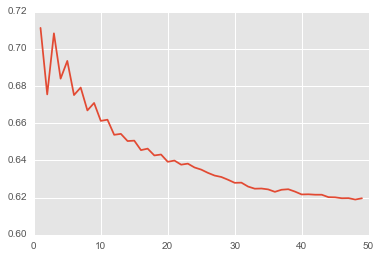

In [98]:
plt.plot(score_df.k, score_df.Score)

In [ ]:
score_df[score_df.Score ==score_df.Score.max()]

In [ ]:
train_X = KNN_train_df
KNN_model = neighbors.KNeighborsClassifier(n_neighbors = 10, weights = 'distance')
KNN_model.fit(train_X, train_y)

In [ ]:
k = range(1, 50)

score_df = pd.DataFrame({'k': k})

models = score_df.\
    apply(lambda row: neighbors.KNeighborsClassifier(n_neighbors = row['k'], weights = 'distance').fit(train_X, train_y), axis = 1)

models

score_df['Score'] = models.map(lambda model: model.score(train_X, train_y))

In [ ]:
plt.plot(score_df.k, score_df.Score)

In [ ]:
score_df[score_df.Score ==score_df.Score.max()].min()

In [ ]:
KNN_model = neighbors.KNeighborsClassifier(n_neighbors = 15, weights = 'distance')
KNN_model.fit(train_X, train_y)

KNN Summary: Seems like the best KNN model is k=1 for uniform model and k=15 for distance weighted model.

#### Random Forest

In [ ]:
train_X =  train_2_df[['SHOT_NUMBER','GAME_CLOCK_t','Catch&Shot','SHOT_CLOCK','SHOT_DIST','CLOSE_DEF_DIST']]

In [ ]:
train_X.head(2)

In [ ]:
# 10K trees
random_forest_10K = ensemble.RandomForestClassifier(n_estimators = 10000,
        max_features = 4,
        min_samples_leaf = 5,
        oob_score = True,
        random_state = 0).\
    fit(train_X, train_y)

In [ ]:
random_forest.oob_score_

In [ ]:
cross_validation.cross_val_score(random_forest, train_X, train_y, cv = 10).mean()